In [1]:
'''
Learn Covid Platform COVID-19 Impact
'''

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.statespace.sarimax import SARIMAX



plt.style.use('seaborn-whitegrid') #Seaborn style


In [2]:
# List all files available
districts = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data = os.path.join(dirname, filename)
        # print(os.path.join(dirname, filename))

# Districts Info
We dropped all the values with Nan from districts

In [3]:
# Districts Info 
#filtrar datos en base a district_info.csv
%time
districts_path = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv"
districts_info_df = pd.read_csv(districts_path)
print(districts_info_df.info())
print(districts_info_df.head())
print(districts_info_df.isna().sum())
print("==Delete all district that has state as NaN")
districts_info_df = districts_info_df[districts_info_df.state.notna()].reset_index(drop=True)
print(districts_info_df.isna().sum())
print(districts_info_df.head())
districts_info_df = pd.read_csv(districts_path)
print(districts_info_df.info())
print(districts_info_df.head())
print(districts_info_df.isna().sum())
print("==Delete all district that has state as NaN")
districts_info_df = districts_info_df[districts_info_df.state.notna()].reset_index(drop=True)
print(districts_info_df.isna().sum())
print(districts_info_df.head())

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     176 non-null    object
 2   locale                    176 non-null    object
 3   pct_black/hispanic        176 non-null    object
 4   pct_free/reduced          148 non-null    object
 5   county_connections_ratio  162 non-null    object
 6   pp_total_raw              118 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB
None
   district_id     state  locale pct_black/hispanic pct_free/reduced  \
0         8815  Illinois  Suburb           [0, 0.2[         [0, 0.2[   
1         2685       NaN     NaN                NaN              NaN   
2         4921      Utah  Suburb           [0, 0.2[       [0.2, 0.4[   
3 

In [4]:
%time
products_path = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv"
products_info_df = pd.read_csv(products_path)
# Rename column "LP ID"
# prod_cols = products_info_df.columns.tolist()
# prod_cols[0] = "lp_id"
# products_info_df.columns=prod_cols
# products_info_df.head()

temp_sectors = products_info_df['Sector(s)'].str.get_dummies(sep="; ")
temp_sectors.columns = [f"sector_{re.sub(' ', '', c)}" for c in temp_sectors.columns]
products_info_df = products_info_df.join(temp_sectors)
products_info_df.drop("Sector(s)", axis=1, inplace=True)

del temp_sectors

products_info_df['primary_function_main'] = products_info_df['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if x == x else x)
products_info_df['primary_function_sub'] = products_info_df['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if x == x else x)

# Synchronize similar values
products_info_df['primary_function_sub'] = products_info_df['primary_function_sub'].replace({'Sites, Resources & References' : 'Sites, Resources & Reference'})
products_info_df.drop("Primary Essential Function", axis=1, inplace=True)

print(products_info_df.head())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
   LP ID                           URL  Product Name  Provider/Company Name  \
0  13117    https://www.splashmath.com   SplashLearn          StudyPad Inc.   
1  66933          https://abcmouse.com  ABCmouse.com  Age of Learning, Inc    
2  50479         https://www.abcya.com        ABCya!         ABCya.com, LLC   
3  92993         http://www.aleks.com/         ALEKS    McGraw-Hill PreK-12   
4  73104  https://www.achieve3000.com/   Achieve3000            Achieve3000   

   sector_Corporate  sector_HigherEd  sector_PreK-12 primary_function_main  \
0                 0                0               1                    LC   
1                 0                0               1                    LC   
2                 0                0               1                    LC   
3                 0                1               1                    LC   
4                 0                0               1                   

In [5]:
districts_info_df.sort_values(by="district_id", ascending=True)

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
83,1000,Connecticut,Suburb,"[0.6, 0.8[","[0.2, 0.4[","[0.18, 1[",NaN
7,1044,Missouri,Suburb,"[0, 0.2[","[0, 0.2[",NaN,"[10000, 12000["
114,1052,Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[16000, 18000["
35,1142,Connecticut,Rural,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[",NaN
117,1204,Utah,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[6000, 8000["
...,...,...,...,...,...,...,...
31,9589,Connecticut,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[",NaN
97,9778,Utah,Town,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[8000, 10000["
5,9812,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
43,9899,Illinois,Suburb,"[0.2, 0.4[","[0, 0.2[","[0.18, 1[","[12000, 14000["


# Products Info

# Engagement Data
We are only considering districts with full 2020 engagement data to avoid some errors and bias on incomplete data.

In [6]:
%time

ENGAGEMENT_PATH = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data"

temp = []

for district in districts_info_df.district_id.unique():
    df = pd.read_csv(f'{ENGAGEMENT_PATH}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    if df.time.nunique() == 366:
        temp.append(df)

all_engagement_df = pd.concat(temp)
all_engagement_df = all_engagement_df.reset_index(drop=True)

# Only consider districts with full 2020 engagement data
districts_info_df = districts_info_df[districts_info_df.district_id.isin(all_engagement_df.district_id.unique())].reset_index(drop=True)
products_info_df = products_info_df[products_info_df['LP ID'].isin(all_engagement_df.lp_id.unique())].reset_index(drop=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [7]:
#Printing the total number of rowns in engagement
all_engagement_df = all_engagement_df[all_engagement_df.lp_id.isin(products_info_df['LP ID'].unique())]
print(len(all_engagement_df))

7784803


In [8]:
# Fix date column
all_engagement_df.time = all_engagement_df.time.astype('datetime64[ns]')

In [9]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

districts_info_df['state_abbrev'] = districts_info_df['state'].replace(us_state_abbrev)
districts_info_by_state = districts_info_df['state_abbrev'].value_counts().to_frame().reset_index(drop=False)
districts_info_by_state.columns = ['state_abbrev', 'num_districts']

# Number of Available School Districts per State

In [10]:
fig = go.Figure()
layout = dict(
    title_text = "Available School Districts in each State",
    geo_scope='usa',
)

fig.add_trace(
    go.Choropleth(
        locations=districts_info_by_state.state_abbrev,
        zmax=1,
        z = districts_info_by_state.num_districts,
        locationmode = 'USA-states', # set of locations match entries in `locations`
        marker_line_color='white',
        geo='geo',
        colorscale=px.colors.sequential.RdBu_r, 
    )
)
            
fig.update_layout(layout)   
fig.show()

In [11]:
#Checking the dtype of each column
all_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7784803 entries, 0 to 14913938
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   time              datetime64[ns]
 1   lp_id             float64       
 2   pct_access        float64       
 3   engagement_index  float64       
 4   district_id       int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 356.4 MB


In [12]:
all_engagement_df.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,15254.0,0.21,2.07,3710
2,2020-01-01,32213.0,0.62,12.40,3710
3,2020-01-01,16633.0,0.21,2.07,3710
4,2020-01-01,94324.0,0.21,6.20,3710
5,2020-01-01,64948.0,0.21,2.07,3710


In [13]:
# All engagement number of rows
all_engagement_df.shape

(7784803, 5)

In [14]:
# Merging the districts with engagement data
engagement_district_df = all_engagement_df.merge(districts_info_df, on="district_id", how="right")
engagement_district_df.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,state_abbrev
0,2020-01-01,15254.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
1,2020-01-01,32213.0,0.62,12.40,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
2,2020-01-01,16633.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
3,2020-01-01,94324.0,0.21,6.20,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
4,2020-01-01,64948.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT


In [15]:
# Merging the districts with engagement data2
engagement_district_df = all_engagement_df.merge(districts_info_df, on="district_id", how="right")
engagement_district_df.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,state_abbrev
0,2020-01-01,15254.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
1,2020-01-01,32213.0,0.62,12.40,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
2,2020-01-01,16633.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
3,2020-01-01,94324.0,0.21,6.20,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT
4,2020-01-01,64948.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT


In [16]:
# View number of registers
engagement_district_df.shape

(7784803, 12)

In [17]:
engagement_district_df.dropna(subset=["lp_id"],inplace=True)
engagement_district_df.shape

(7784803, 12)

In [18]:
# View NA in engagment_district_df 
engagement_district_df.isna().sum()

time                              0
lp_id                             0
pct_access                        0
engagement_index            1536502
district_id                       0
state                             0
locale                            0
pct_black/hispanic                0
pct_free/reduced            1174286
county_connections_ratio     634448
pp_total_raw                2630116
state_abbrev                      0
dtype: int64

In [19]:
products_info_df.isna().sum()

LP ID                     0
URL                       0
Product Name              0
Provider/Company Name     0
sector_Corporate          0
sector_HigherEd           0
sector_PreK-12            0
primary_function_main    19
primary_function_sub     19
dtype: int64

# Number of available data by each State

In [20]:
pd.DataFrame(engagement_district_df.state.value_counts())

,state
Connecticut,1498456
Utah,1117359
Massachusetts,990656
Illinois,945513
Ohio,526962
California,526745
Missouri,479741
Washington,322752
Indiana,313265
Virginia,238750


In [21]:
# Merge engagement_district_df with productos_info_df
# Rename column "LP ID"
prod_cols = products_info_df.columns.tolist()
prod_cols[0] = "lp_id"
products_info_df.columns=prod_cols
engagement_district_product_df = engagement_district_df.merge(products_info_df, on="lp_id", how="left")
engagement_district_product_df.shape

(7784803, 20)

In [22]:
engagement_district_product_df[engagement_district_product_df["URL"].isna()]

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,state_abbrev,URL,Product Name,Provider/Company Name,sector_Corporate,sector_HigherEd,sector_PreK-12,primary_function_main,primary_function_sub


# Lost values on the final table that include Engagement | District | Product
These lost values are cleaned

In [23]:
# NaN in engagement_district_product_df
pd.DataFrame(engagement_district_product_df.isna().sum())

,0
time,0
lp_id,0
pct_access,0
engagement_index,1536502
district_id,0
state,0
locale,0
pct_black/hispanic,0
pct_free/reduced,1174286
county_connections_ratio,634448


In [24]:
# Delete rows with NA in engagement_index
engagement_district_product_df.dropna(subset=["engagement_index"],inplace=True)
engagement_district_product_df.shape

(6248301, 20)

In [25]:
engagement_district_product_df.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,state_abbrev,URL,Product Name,Provider/Company Name,sector_Corporate,sector_HigherEd,sector_PreK-12,primary_function_main,primary_function_sub
0,2020-01-01,15254.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT,http://appinventor.mit.edu/explore/,MIT App Inventor,Massachusetts Institute of Technology,1,1,1,LC,Content Creation & Curation
1,2020-01-01,32213.0,0.62,12.40,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT,https://classroom.google.com,Google Classroom,Google LLC,1,1,1,SDO,Learning Management Systems (LMS)
2,2020-01-01,16633.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT,http://www.cnn.com/cnn10,CNN Student News,Cable News Network,1,1,1,LC,"Sites, Resources & Reference"
3,2020-01-01,94324.0,0.21,6.20,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT,http://www.wevideo.com/education,WeVideo for Schools,"WeVideo, Inc.",1,1,1,LC,Content Creation & Curation
4,2020-01-01,64948.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[6000, 8000[",UT,https://prodigygame.com/,Prodigy,SMARTeacher Inc.,0,0,1,LC,"Sites, Resources & Reference"


# Number of values for each product

In [26]:
pd.DataFrame(engagement_district_product_df['Product Name'].value_counts())

,Product Name
Google Docs,47819
Google Drive,46929
Google Classroom,45285
Google Forms,44119
Google Sites,44091
...,...
Sched,790
School Specialty,787
Cult of Pedagogy,594
Ellevation,422


In [27]:
# Separating data in pct_black/hispanic in different columns
engagement_district_product_df['pct_black'] = engagement_district_product_df['pct_black/hispanic'].map(lambda x: float(x.split(",")[0][1:]))
pd.unique(engagement_district_product_df['pct_black'])
engagement_district_product_df['pct_hispanic'] = engagement_district_product_df['pct_black/hispanic'].map(lambda x: float(x.split(",")[1][:-1]))
pd.unique(engagement_district_product_df['pct_hispanic'])

array([0.2, 0.4, 0.6, 1. , 0.8])

In [28]:
# Separate data in pct_free/reduced in diferent columns
engagement_district_product_df['pct_free'] = engagement_district_product_df['pct_free/reduced'].map(lambda x: float(str(x).split(",")[0][1:]), na_action='ignore')
pd.unique(engagement_district_product_df['pct_free'])
engagement_district_product_df['pct_reduced'] = engagement_district_product_df['pct_free/reduced'].map(lambda x: float(str(x).split(",")[1][:-1]), na_action='ignore')
pd.unique(engagement_district_product_df['pct_reduced'])

array([0.6, 0.4, 0.8, 0.2, nan, 1. ])

# Exploring the Final Table

In [29]:
# Final Dataframe
engagement_district_product_df.head()

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,...,Provider/Company Name,sector_Corporate,sector_HigherEd,sector_PreK-12,primary_function_main,primary_function_sub,pct_black,pct_hispanic,pct_free,pct_reduced
0,2020-01-01,15254.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,Massachusetts Institute of Technology,1,1,1,LC,Content Creation & Curation,0.0,0.2,0.4,0.6
1,2020-01-01,32213.0,0.62,12.40,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,Google LLC,1,1,1,SDO,Learning Management Systems (LMS),0.0,0.2,0.4,0.6
2,2020-01-01,16633.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,Cable News Network,1,1,1,LC,"Sites, Resources & Reference",0.0,0.2,0.4,0.6
3,2020-01-01,94324.0,0.21,6.20,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,"WeVideo, Inc.",1,1,1,LC,Content Creation & Curation,0.0,0.2,0.4,0.6
4,2020-01-01,64948.0,0.21,2.07,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[",...,SMARTeacher Inc.,0,0,1,LC,"Sites, Resources & Reference",0.0,0.2,0.4,0.6


# Interactive Graphics
In this section we will present a series of graphics in which you as a reader can interact and select new parameters, this section uses dropdowns to select the state and different parameters for the the Exploratory Data Analysis (May need to be runned inside Kaggle to be seen)

In [30]:
# Parameters
list_state = list(pd.unique(engagement_district_product_df['state']))
list_products = list(pd.unique(engagement_district_product_df['Product Name']))
list_companies = list(pd.unique(engagement_district_product_df['Provider/Company Name']))
list_locale = list(pd.unique(engagement_district_product_df['locale']))
list_date = list(pd.unique(engagement_district_product_df['time']))

In [31]:
def plot_engagement_state_product(state,product_name):
  global engagement_district_product_df
  df = engagement_district_product_df.loc[engagement_district_product_df['Product Name'] == product_name]
  df2 = df.loc[df['state'] == state]
  data = df2.groupby('time')['engagement_index'].mean()
  # print(df2.groupby('time')['engagement_index'].mean())
  plt.figure(figsize=(18,5))
  plt.plot(data)
  plt.show()

# Mean Engament index by State (dropdown) and product (dropdown)
Use the dropdowns to interact

In [32]:
# Mean Engament_index by date (with state and product_name as parameters)
interact(plot_engagement_state_product, state=list_state, product_name = list_products);

interactive(children=(Dropdown(description='state', options=('Utah', 'North Carolina', 'Missouri', 'Washington…

In [33]:
def plot_engagement_state_company(state,company):
  global engagement_district_product_df
  df = engagement_district_product_df.loc[engagement_district_product_df['Provider/Company Name'] == company]
  df2 = df.loc[df['state'] == state]
  data = df2.groupby('time')['engagement_index'].mean()
  # print(df2.groupby('time')['engagement_index'].mean())
  plt.figure(figsize=(18,5))
  plt.plot(data)
  plt.show()

# Mean Engament index by State (dropdown) and Companies (dropdown)
Use the dropdowns to interact

In [34]:
# Mean Engament_index by date (with state and company as parameters)
interact(plot_engagement_state_company, state=list_state, company = list_companies);

interactive(children=(Dropdown(description='state', options=('Utah', 'North Carolina', 'Missouri', 'Washington…

In [35]:
def plot_engagement_state_locale(state,locale):
  global engagement_district_product_df
  df = engagement_district_product_df.loc[engagement_district_product_df['locale'] == locale]
  df2 = df.loc[df['state'] == state]
  data = df2.groupby('time')['engagement_index'].mean()
  # print(df2.groupby('time')['engagement_index'].mean())
  plt.figure(figsize=(18,5))
  plt.plot(data)
  plt.show()

# Mean Engament index by date by State (Dropdown) and Locale (Dropdown)
Use the dropdowns to interact

In [36]:
# Mean Engament_index by date (with state and locale/type of state as parameters)
interact(plot_engagement_state_locale, state=list_state, locale = list_locale);

interactive(children=(Dropdown(description='state', options=('Utah', 'North Carolina', 'Missouri', 'Washington…

In [37]:
def map_by_product_time(product,time):
    global engagement_district_product_df
    df = engagement_district_product_df.loc[engagement_district_product_df['Product Name'] == product]
    df2 = df.loc[df['time'] == time]
    data = df2.groupby('state_abbrev')['engagement_index'].mean().to_frame().reset_index(drop=False)
    
    data.columns = ['state_abbrev', 'mean_engagement']
    
    fig = go.Figure()
    layout = dict(
        title_text = "Average Engagement Index by State",
        geo_scope='usa',
    )

    fig.add_trace(
        go.Choropleth(
            locations=data.state_abbrev,
            zmax=1,
            z = data.mean_engagement,
            locationmode = 'USA-states', # set of locations match entries in `locations`
            marker_line_color='white',
            geo='geo',
            colorscale=px.colors.sequential.RdBu_r, 
        )
    )

    fig.update_layout(layout)   
    fig.show()

# Mean Engament index by date by State (Dropdown) and Locale (Dropdown)
Use the dropdowns to interact

In [38]:
# Mean Engament_index by state in a map (with product and time as parameters)
interact(map_by_product_time, product=list_products, time = list_date);

interactive(children=(Dropdown(description='product', options=('MIT App Inventor', 'Google Classroom', 'CNN St…

# Most Popular
In this section we present an analysis of most popular products

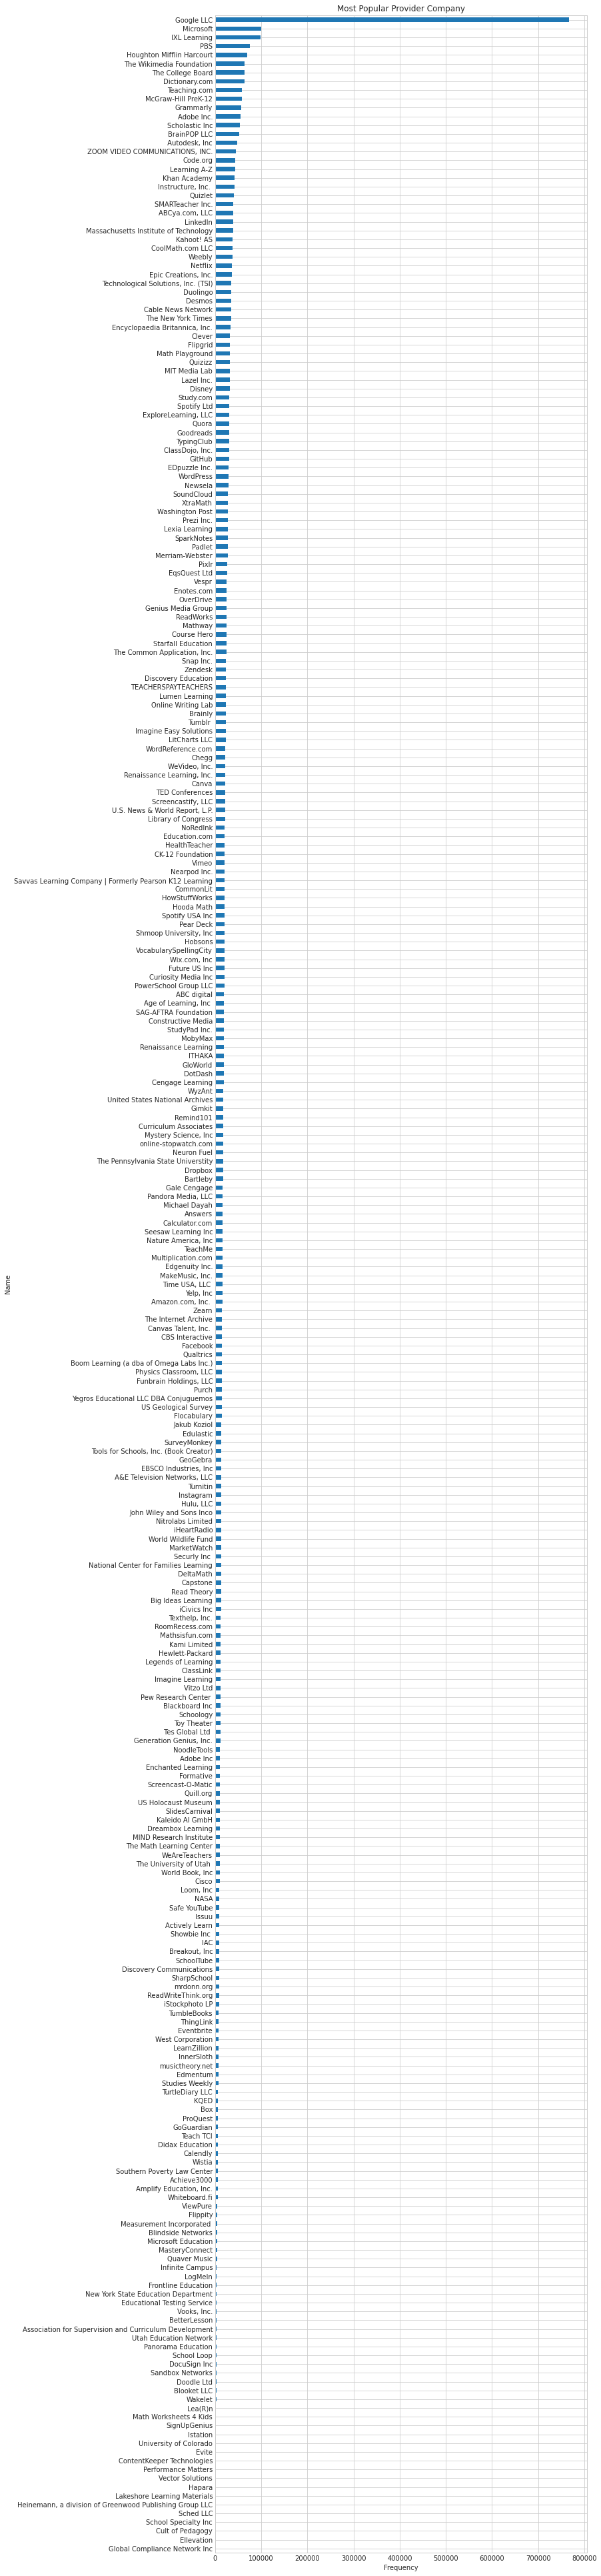

In [39]:
# Which is the most popular company
plt.figure(figsize=(10,70))
engagement_district_product_df['Provider/Company Name'].value_counts().sort_values(ascending=True).plot.barh()
plt.title("Most Popular Provider Company")
plt.ylabel("Name")
plt.xlabel("Frequency");

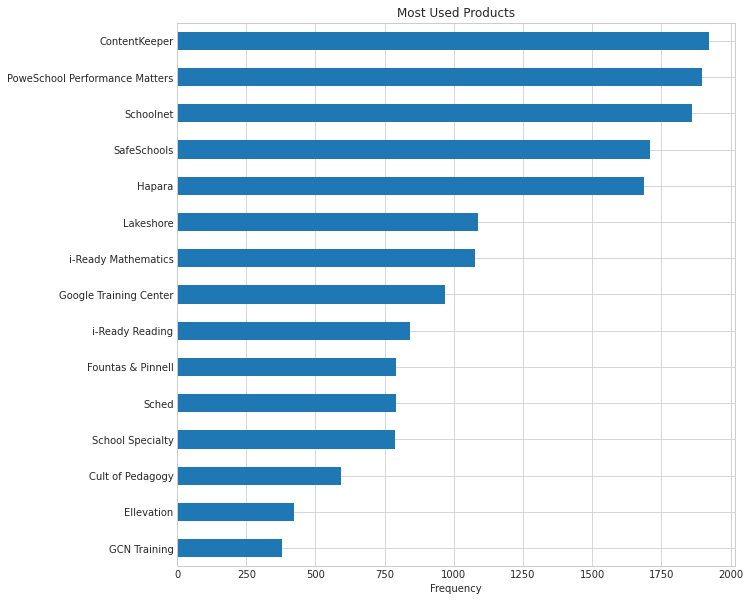

In [40]:
# Which is the most used product
plt.figure(figsize=(10,10))
engagement_district_product_df['Product Name'].value_counts().sort_values(ascending=True)[0:15].plot.barh()
plt.xlabel("Frequency")
plt.title("Most Used Products");


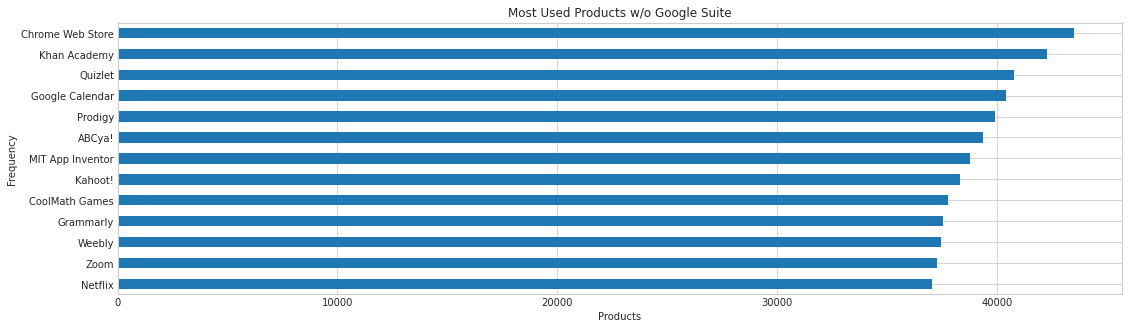

In [41]:
# Which is the most used product
plt.figure(figsize=(18,5))
engagement_district_product_df['Product Name'].value_counts()[7:20].sort_values(ascending=True).plot.barh()
plt.ylabel("Frequency")
plt.xlabel("Products")
plt.title("Most Used Products w/o Google Suite");

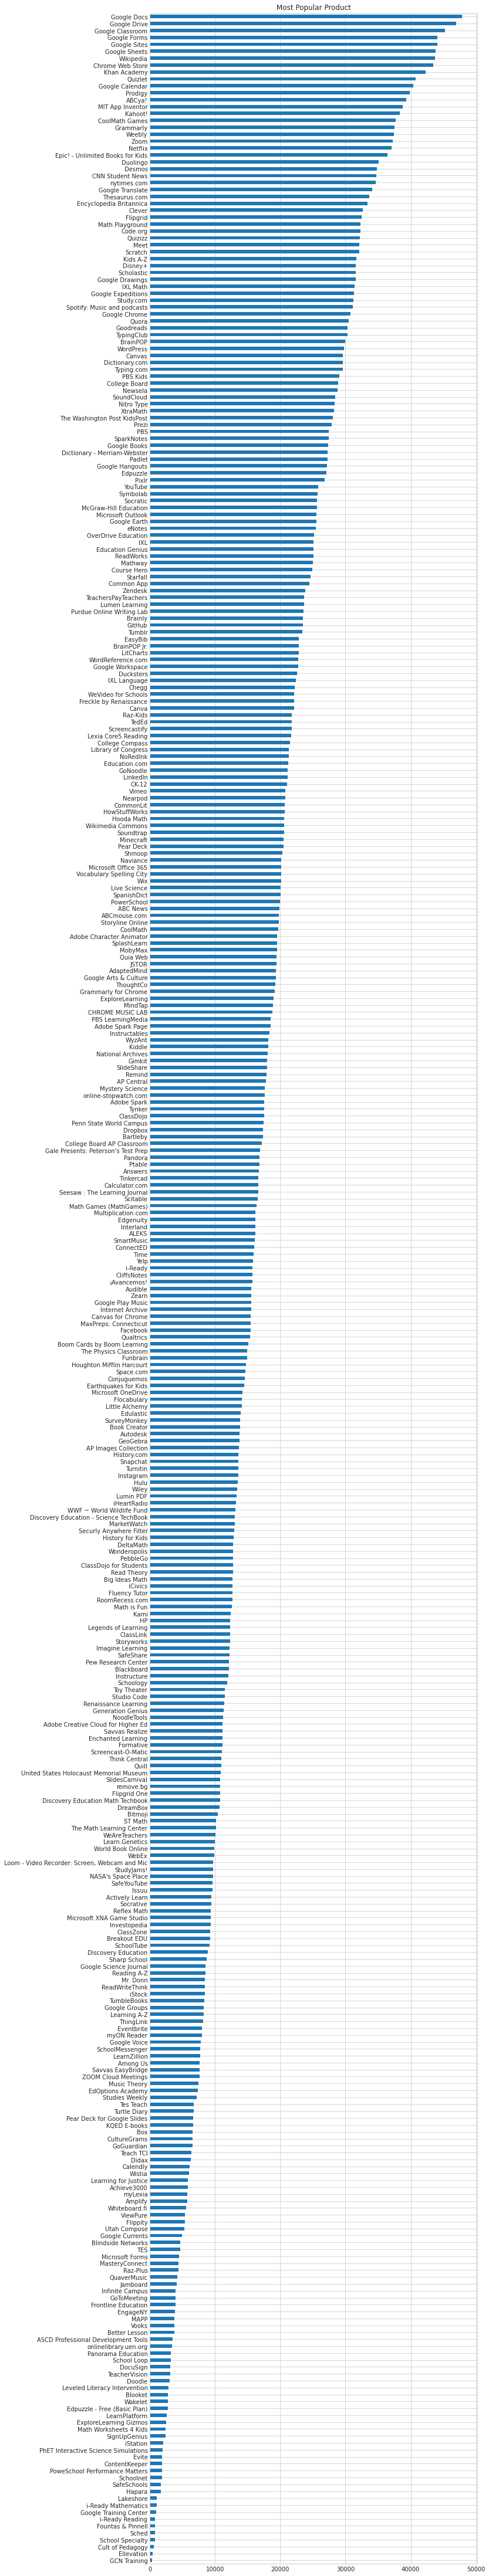

In [42]:
# Which is the most popular product
plt.figure(figsize=(10,80))
engagement_district_product_df['Product Name'].value_counts().sort_values(ascending=True).plot.barh();
plt.title("Most Popular Product");

In [43]:
# Most popular products 
most_popular_products = engagement_district_product_df['Product Name'].value_counts()[0:20]
most_popular_products = most_popular_products.index.tolist()
most_popular_products

['Google Docs',
 'Google Drive',
 'Google Classroom',
 'Google Forms',
 'Google Sites',
 'Google Sheets',
 'Wikipedia',
 'Chrome Web Store',
 'Khan Academy',
 'Quizlet',
 'Google Calendar',
 'Prodigy',
 'ABCya!',
 'MIT App Inventor',
 'Kahoot!',
 'CoolMath Games',
 'Grammarly',
 'Weebly',
 'Zoom',
 'Netflix']

# Relation of Engagement and Deaths in USA
In this section we will present an analysis about the posibbly relation into engagement and number of deaths caused by Covid-19

In [44]:
# Import extra libraries
import datetime
import glob
from ipywidgets import interact, interactive, fixed, interact_manual

# Create a list with path to daily report of covid-19 data for every day of 2020
COVID_PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us"
numdays = 366
base = datetime.date(2020, 1, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
covid_path_list = []
temp = []
for date in date_list:
  day = str(date.day)
  if len(day)==1:
    day = "0"+day

  month = str(date.month)
  if len(month)==1:
    month = "0"+month

  path = COVID_PATH + "/"+month +"-" +day +"-" +str(date.year)+".csv"
  covid_path_list.append(path)

# Read and append only files from 4th of April (first case) to the end of year 2020.
for filename in covid_path_list[102:]:
  df_1 = pd.read_csv(filename, index_col=None, header=0)
  temp.append(df_1)

# Create database from extracted data
all_covid_cases_df = pd.concat(temp)
all_covid_cases_df = all_covid_cases_df.reset_index(drop=True)

In [45]:
engagement_district_product_df_1 = engagement_district_product_df[4065:]
print(all_covid_cases_df.head())
print(engagement_district_product_df_1.head())
print(engagement_district_product_df.head())

  Province_State Country_Region          Last_Update      Lat     Long_  \
0        Alabama             US  2020-04-12 23:18:15  32.3182  -86.9023   
1         Alaska             US  2020-04-12 23:18:15  61.3707 -152.4044   
2        Arizona             US  2020-04-12 23:18:15  33.7298 -111.4312   
3       Arkansas             US  2020-04-12 23:18:15  34.9697  -92.3731   
4     California             US  2020-04-12 23:18:15  36.1162 -119.6816   

   Confirmed  Deaths  Recovered   Active  FIPS  Incident_Rate  People_Tested  \
0       3667      93        NaN   3470.0   1.0      75.988020        21583.0   
1        272       8       66.0    264.0   2.0      45.504049         8038.0   
2       3542     115        NaN   3427.0   4.0      48.662422        52289.0   
3       1280      27      367.0   1253.0   5.0      49.439423        19722.0   
4      22137     645        NaN  22155.0   6.0      58.137726       190328.0   

   People_Hospitalized  Mortality_Rate         UID ISO3  Testing_Rat

In [46]:
print(all_covid_cases_df.columns)
# Sepparate colum "Last_Update", which has hour and date of report, into a column that only has date, and another that only has hour
all_covid_cases_df[['time', 'LU_hour']] = all_covid_cases_df['Last_Update'].str.split(' ',4,expand=True)

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3',
       'Testing_Rate', 'Hospitalization_Rate', 'Total_Test_Results',
       'Case_Fatality_Ratio'],
      dtype='object')


In [47]:
# Function. Graphs reported cases of Covid-19 according to date, and Engagement of a Given product by State during 2020. 
# Two plots are made
def get_covid_graph(Province_State, product_name):
  global all_covid_cases_df
  df_c = all_covid_cases_df.loc[all_covid_cases_df['Province_State'] == Province_State]
  data_c = df_c.groupby('time')['Confirmed'].mean()
  plt.figure(figsize=(30,5))
  plt.plot(data_c)
  plt.show()

  global engagement_district_product_df_1
  df = engagement_district_product_df_1.loc[engagement_district_product_df_1['Product Name'] == product_name]
  df2 = df.loc[df['state'] == Province_State]
  data = df2.groupby('time')['engagement_index'].mean()
  
  plt.figure(figsize=(30,5))
  plt.plot(data)
  plt.show()

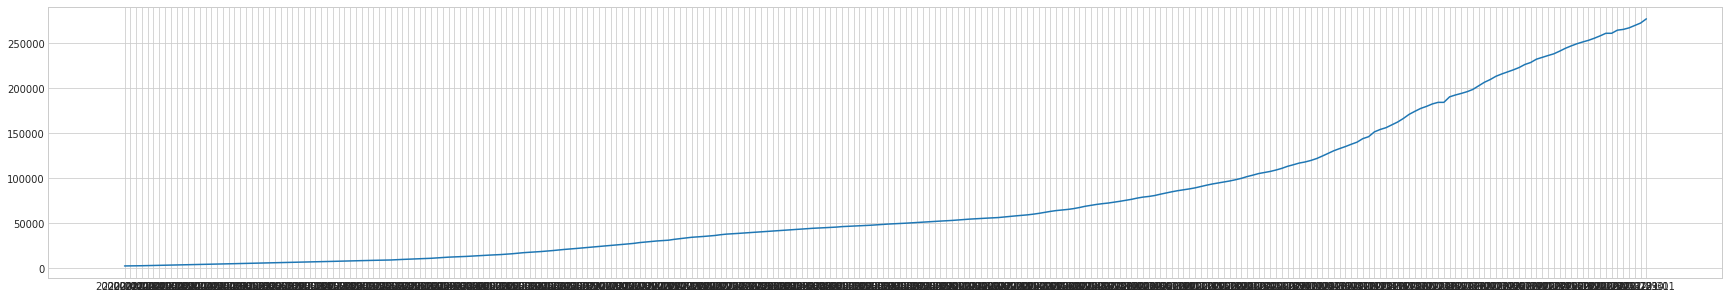

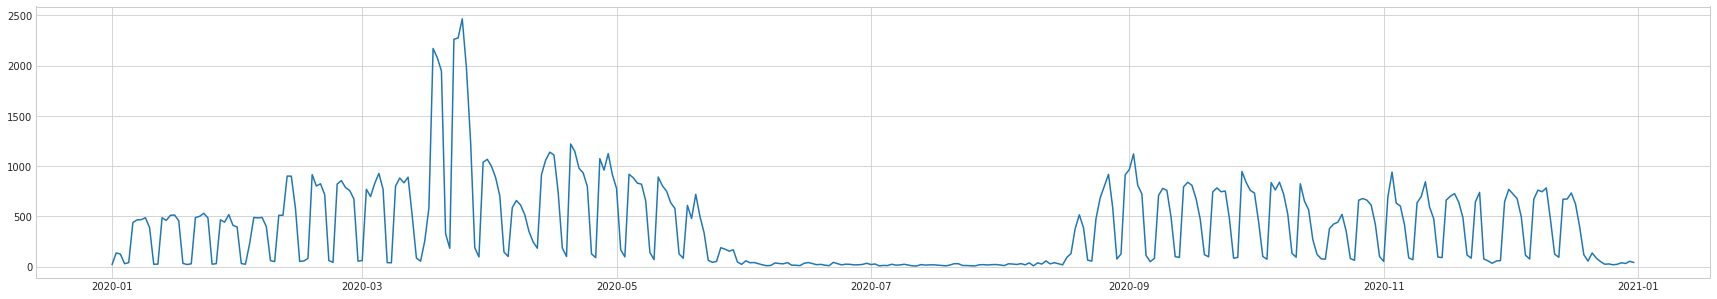

In [48]:
# Example of Function. Using Utah as a State and Google Drive as the product to analize engagement.
get_covid_graph('Utah', 'Google Drive')

In [49]:
# Use of Python's interact function to create a small UI to control Province State and Product Name interactively 
interact(get_covid_graph, Province_State=['Connecticut', 'Utah', 'Massachusetts', 'Illinois', 'California', 'Ohio', 'Missouri', 'Indiana', 'Washington', 'Virginia', 'North Carolina', 'New Jersey', 'New Hampshire', 'Michigan', 'District Of Columbia', 'Arizona', 'New York', 'Tennessee', 'Florida'], product_name=['Google Drive','YouTube','Google Classroom']);

interactive(children=(Dropdown(description='Province_State', options=('Connecticut', 'Utah', 'Massachusetts', …

# Forecasting of engagement_index


In [50]:
# Forecast based in product_name and state
def forecasting(product_name,state):
  global engagement_district_product_df
  df = engagement_district_product_df.loc[engagement_district_product_df['Product Name'] == product_name]
  df2 = df.loc[df['state'] == state]
  print(df2.shape)
  data = df2.groupby('time')['engagement_index'].mean().values
  print( df.loc[df['state'] == state])
  # fit model
  model = SARIMAX(data, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))
  model_fit = model.fit(disp=False)
  # make prediction
  yhat = model_fit.predict()
  print(len(yhat))
  return yhat

(8350, 24)
              time    lp_id  pct_access  engagement_index  district_id state  \
9       2020-01-02  95731.0        0.62             12.40         3710  Utah   
30      2020-01-04  95731.0        0.62             14.46         3710  Utah   
38      2020-01-05  95731.0        0.62             30.99         3710  Utah   
51      2020-01-06  95731.0        7.42           1894.85         3710  Utah   
76      2020-01-07  95731.0        8.25           1690.72         3710  Utah   
...            ...      ...         ...               ...          ...   ...   
7388644 2020-12-27  95731.0        0.75            654.70         3266  Utah   
7388762 2020-12-28  95731.0        0.90            385.72         3266  Utah   
7388803 2020-12-29  95731.0        0.97            501.40         3266  Utah   
7388924 2020-12-30  95731.0        0.88            606.84         3266  Utah   
7388986 2020-12-31  95731.0        0.95            542.99         3266  Utah   

         locale pct_black/hi

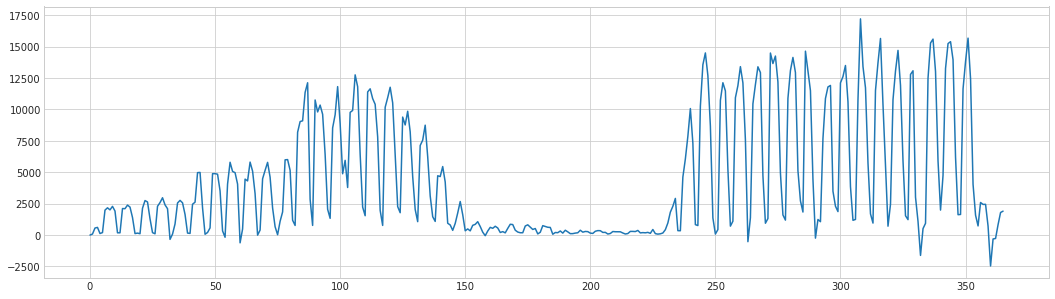

In [51]:
predictions = forecasting("Google Docs","Utah")
plt.figure(figsize=(18,5))
plt.plot(predictions)
plt.show()

In [52]:
#Weekend Eradication
def weekendEr(predictions):
  a=2
  global engagement_district_product_df
  arr=[]
  x=0
  
  while(x<366):
    x+=1
    if(x==a or x==a+1):
      if(x==a):
        arr.append(x)
      else:
        arr.append(x)
        a=a+6

  print(len(arr))
  print(predictions.shape)
  
  predictions2=pd.DataFrame(predictions)
  predictions2.drop(labels=arr, axis=0,  columns=None, level=None, inplace=True, errors='raise')
  pred=predictions2.to_numpy()
  print(predictions2.shape)
  return predictions2

In [53]:
#promedy for 5 days
def med(predictions):
  a=0
  sum=0
  arr=[]
  for x in range(365):
    if(a==4):
      arr.append(sum/5)
      sum=0
      a=0
    sum=sum+predictions[x]
    a+=1
  predictions2=pd.DataFrame(arr)
  return predictions2

<bound method NDFrame.head of               0
0    250.541998
1    895.167821
2   1276.486929
3   1354.909131
4    778.803852
..          ...
86  7432.492013
87  8549.256498
88  3756.636315
89  1638.700823
90  -441.342176

[91 rows x 1 columns]>


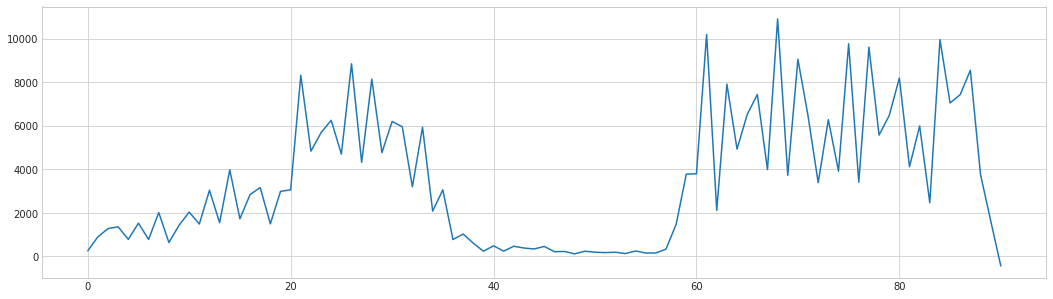

In [54]:
#average data every 5 days
predictionsEradication = med(predictions)
print(predictionsEradication.head)
plt.figure(figsize=(18,5))
plt.plot(predictionsEradication)
plt.show()

In [55]:
#promedy for 5 days
def comparison(engagement_comparison):
  nmp=engagement_comparison.to_numpy()
  #First part of the year 152 days 
  a=0
  #we take out 92 days that are the summer vacation
  #the second part of the year will be conforme by 108 days because
  #we take out the last 2 weeks of december for vacations
  b=244
  sum=0
  sum2=0
  arr=[]
  for x in range(152):
    sum=sum+nmp[x]

  for y in range(108):
    sum2=sum2+nmp[y+244]

  arr.append(sum/152)
  arr.append(sum2/108)
  comp=pd.DataFrame(arr)
  return comp


In [56]:
#comparison of engagement in the first half of the year and in the last half of the year, taking out the vacations 
comp=comparison(engagement_district_product_df['engagement_index'])
print(comp.shape)
print(comp.head)
# print(engagement_district_product_df['engagement_index'].shape)

(2, 1)
<bound method NDFrame.head of             0
0  148.838289
1  118.922963>


We can infer that in the first 2020 semester the engagement_index average was greather than the second 2020 semester